# Taxi Tip Prediction!

Consolidate your machine learning (ML) modeling skills by using a popular regression model: Decision Tree. You will use a real dataset to train such a model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). You will use the trained model to predict the amount of tip paid

In [25]:
# download the taxi trip data set
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv

--2023-06-16 18:47:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364904448 (348M) [text/csv]
Saving to: ‘yellow_tripdata_2019-06.csv.8’

yellow_tripdata_201 100%[===================>] 348.00M  37.5MB/s    in 8.9s    

2023-06-16 18:48:11 (38.9 MB/s) - ‘yellow_tripdata_2019-06.csv.8’ saved [364904448/364904448]



In [26]:
# install packages and import libraries

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [27]:
# Read the Input Data

raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print('there are' + str(len(raw_data)) + 'observation is in the data set')
print('there are' + str(len(raw_data.columns)) + 'variables in the dataset')

raw_data.head()

there are3936004observation is in the data set
there are18variables in the dataset


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [28]:
# lets reduce the data size to 100000 records

raw_data = raw_data.head(100000)

there are65349observations in the dataset
there are17variables in the dataset


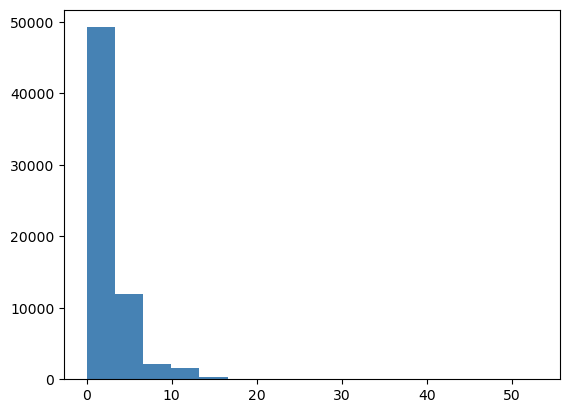

min 0.01
max 53.0
Percentile 5.15


In [29]:
# train the model tha tuses theother variables to predict,
# the values pf the trip_amount variable.

# some trips report 0 tips, It is assumed that these trips were pain for
raw_data = raw_data[raw_data['tip_amount'] > 0]

#we also remove some outliers
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with large fair cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it
clean_data = raw_data.drop(['total_amount'], axis=1)

# make sure we dont ru out of memory wiht the large data set
del raw_data
gc.collect()

# print the number of trips left
print('there are' + str(len(clean_data)) + 'observations in the dataset')
print('there are' + str(len(clean_data.columns)) + 'variables in the dataset')

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='steelblue')
plt.show()

print('min', np.min(clean_data.tip_amount.values))
print('max', np.max(clean_data.tip_amount.values))
print('Percentile', np.percentile(clean_data.tip_amount.values, 90))
                    

In [30]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


## DATA PRE-PROCESSING

In [31]:
#pre paring the data for training

clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

# ideally use the full dataset for this exercise
# however if you run into out of memory issues due to the data size, reduce it
# for instance, in this example we use only the first 1M samples
first_n_rows = 1000000
clean_data = clean_data.head(first_n_rows)

In [32]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

3736

In [33]:
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (65349, 460) y.shape= (65349, 1)


## Dataset Train/ Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)


X_train.shape= (45744, 460) Y_train.shape= (45744, 1)
X_test.shape= (19605, 460) Y_test.shape= (19605, 1)


### Building Decession tree regression models

In [41]:
# import the decision tree

from sklearn.tree import DecisionTreeRegressor

sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train the data set
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print('[Scikit-Learn] Training Time (s): {0:.5f}'.format(sklearn_time))

[Scikit-Learn] Training Time (s): 1.79670


## Build a decision tree regressor model with Snap ML

In [42]:
from snapml import DecisionTreeRegressor

snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

t0= time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print('[Snap ML] Training time (s): {0:.5f}'.format(snapml_time))

[Snap ML] Training time (s): 2.36784


## Evaluationg the Scikit-Learn and Snap ML

In [44]:
# Snap ML vs Scikit-Learn
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 0.76x 
[Scikit-Learn] MSE score : 1.615
[Snap ML] MSE score : 1.690
